In [1]:
# pip install dpyacl

     |████████████████████████████████| 48 kB 1.9 MB/s eta 0:00:011
  Created wheel for dpyacl: filename=dpyacl-0.3-py3-none-any.whl size=53903 sha256=cf1778dfc9dcf6a82f4857d00444e6a01a82a5f1ffaab847720696478dea3211
  Stored in directory: /home/jovyan/.cache/pip/wheels/84/78/bc/90f1c59739cc83e011143a4436d31b57dbfef0b140ad84355a
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13698 sha256=fb2d7a43c37884ed11a35ea6181cb0c77a0ac48a749ecd9d5d5e840226213449
  Stored in directory: /home/jovyan/.cache/pip/wheels/8c/76/0b/eb9eb3da7e2335e3577e3f96a0ae9f74f206e26457bd1a2bc8
Successfully built dpyacl prettytable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from dask.distributed import Client

# remote Distributed Mode
client = Client('tcp://192.168.2.100:8786')

# Local Multi-thread
# client = Client(processes=False, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Multi-Process
# client = Client(processes=True, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Single-Thread
# client = None

In [2]:
from sklearn.datasets import load_breast_cancer

X,y=load_breast_cancer(return_X_y=True) #import the dataset


In [2]:
X

dask.array<array, shape=(150, 4), dtype=float64, chunksize=(150, 4), chunktype=numpy.ndarray>

In [3]:
from sklearn.linear_model import LogisticRegression
from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.strategies.single_label import QueryMarginSampling
from dpyacl.metrics.evaluation import Accuracy, F1, HammingLoss
from dpyacl.oracle import SimulatedOracle

ml_technique = LogisticRegression(solver='sag')
stopping_criteria = MaxIteration(25)
query_strategy = QueryMarginSampling()
performance_metrics = [Accuracy(),  F1(average='weighted'), HammingLoss()]
oracle = SimulatedOracle(labels=y)

In [4]:
from dpyacl.experiment.context import CrossValidationExperiment
from dpyacl.scenario import PoolBasedSamplingScenario

# init the ALExperiment
experiment = CrossValidationExperiment(
    client = None,
    X=X,
    Y=y,
    scenario_type=PoolBasedSamplingScenario,
    ml_technique=ml_technique,
    performance_metrics=performance_metrics,
    query_strategy=query_strategy,
    oracle=SimulatedOracle(labels=y),
    stopping_criteria=stopping_criteria,
    self_partition=True,
    kfolds=10,
    test_ratio=0.3,
    initial_label_rate=0.05,
    all_class=True,
    batch_size=10
)

In [5]:
%%time
import time

start_time = time.time()
results = experiment.evaluate(client= client, verbose=True)
end_time = time.time() - start_time
print(end_time)

228.41981077194214
CPU times: user 1.38 s, sys: 104 ms, total: 1.48 s
Wall time: 3min 48s


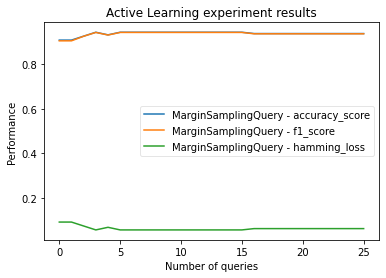

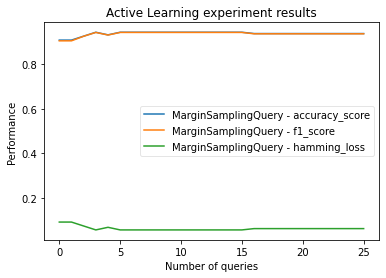

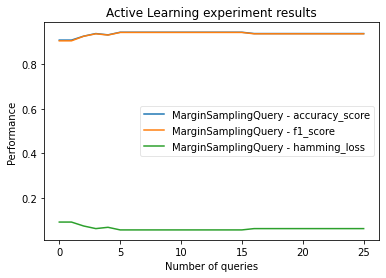

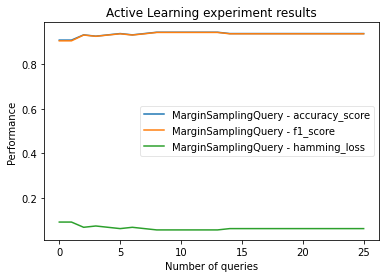

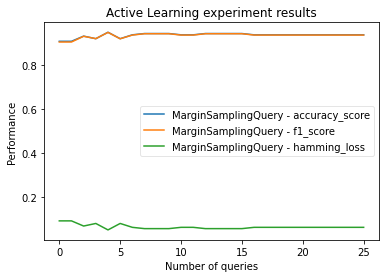

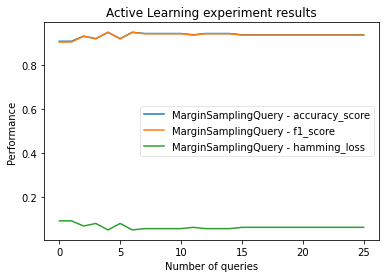

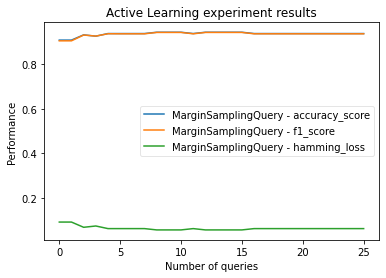

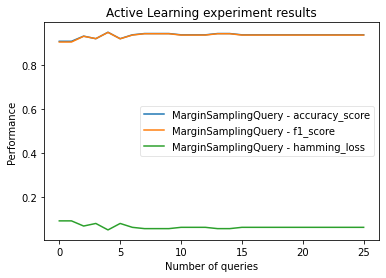

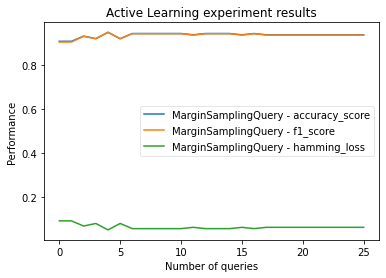

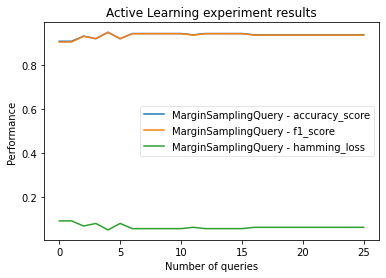

In [6]:
from dpyacl.experiment import ExperimentAnalyserFactory

for result in results:
    query_analyser = ExperimentAnalyserFactory.experiment_analyser(
        performance_metrics=[metric.metric_name for metric in performance_metrics],
        method_name=query_strategy.query_function_name,
        method_results=result,
        type="queries"
    )

    # get a brief description of the experiment
    query_analyser.plot_learning_curves(title='Active Learning experiment results')